In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
!pip install xgboost
%matplotlib inline

In [ ]:
data = pd.read_csv('./insurance.csv')
data.head()

In [ ]:
data.info()

### There are no missing values as such

In [ ]:
data['region'].value_counts().sort_values()

In [ ]:
data['children'].value_counts().sort_values()

### Converting Categorical Features to Numerical

In [65]:
pd.set_option('future.no_silent_downcasting', True)

clean_data = {'sex': {'male' : 0 , 'female' : 1} ,
                 'smoker': {'no': 0 , 'yes' : 1},
                   'region' : {'northwest':0, 'northeast':1,'southeast':2,'southwest':3}
               }
data_copy = data.copy()
data_copy.replace(clean_data, inplace=True)

In [66]:
data_copy.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


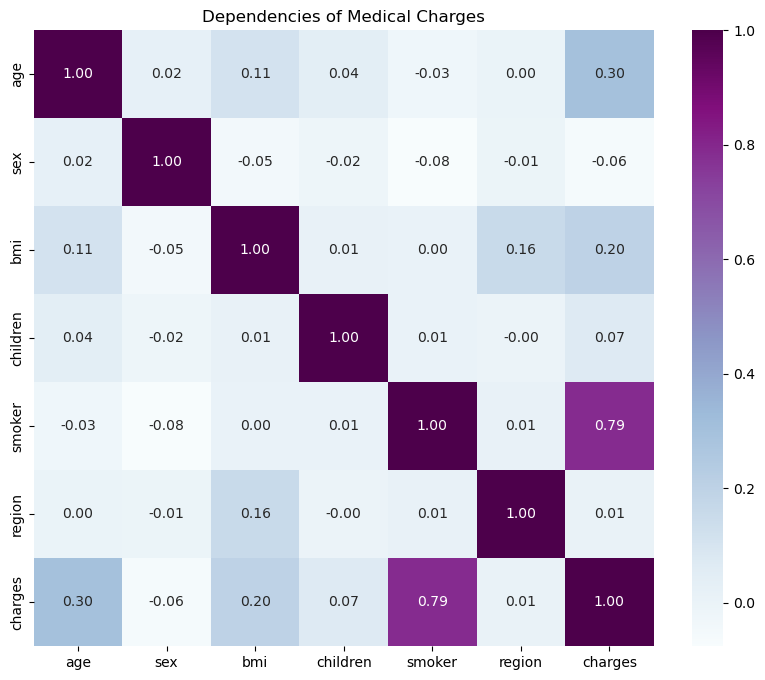

In [67]:
import os
# Ensure the directory exists
os.makedirs('sampleImages', exist_ok=True)
corr = data_copy.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr,cmap='BuPu',annot=True,fmt=".2f",ax=ax)
plt.title("Dependencies of Medical Charges")
plt.savefig('./sampleImages/Cor.png')
plt.show()

### Smoker, BMI and Age are most important factor that determnines - Charges
Also we see that Sex, Children and Region do not affect the Charges.
We might drop these 3 columns as they have less correlation

In [68]:
print(data['sex'].value_counts().sort_values()) 
print(data['smoker'].value_counts().sort_values())
print(data['region'].value_counts().sort_values())

sex
female    662
male      676
Name: count, dtype: int64
smoker
yes     274
no     1064
Name: count, dtype: int64
region
northeast    324
southwest    325
northwest    325
southeast    364
Name: count, dtype: int64


### Now we are confirmed that there are no other values in above pre-preocessed column, We can proceed with EDA

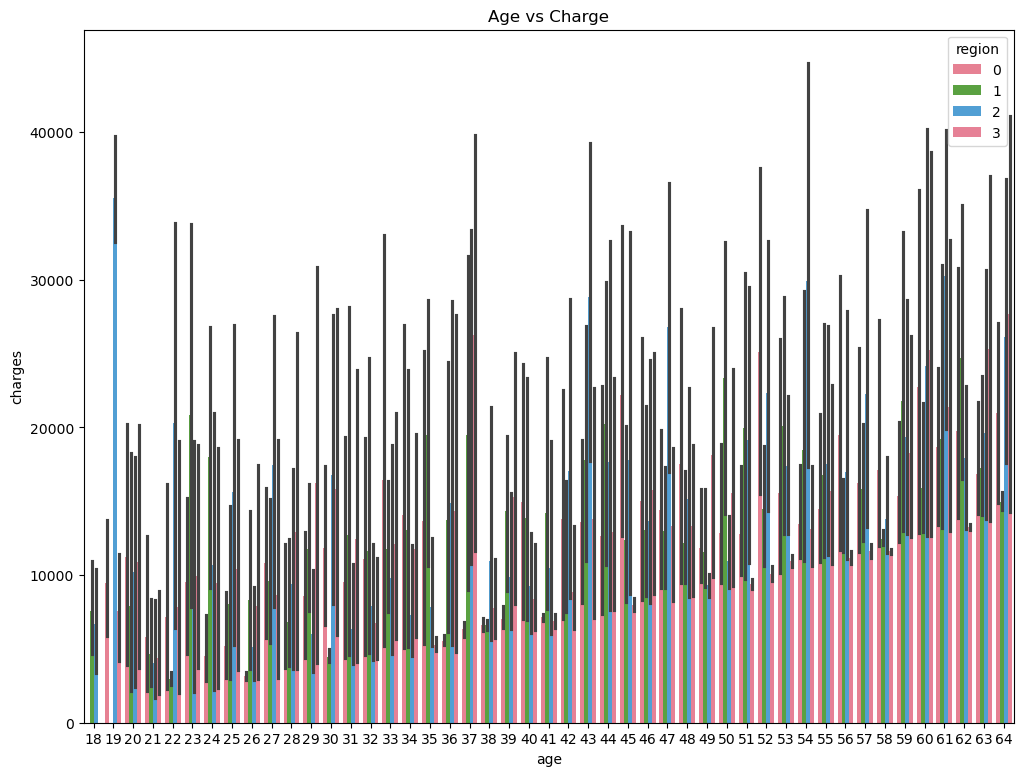

In [72]:
plt.figure(figsize=(12,9))
plt.title('Age vs Charge')
sns.barplot(x='age',y='charges',data=data_copy,hue='region', palette='husl')
plt.savefig('./sampleImages/AgevsCharges')

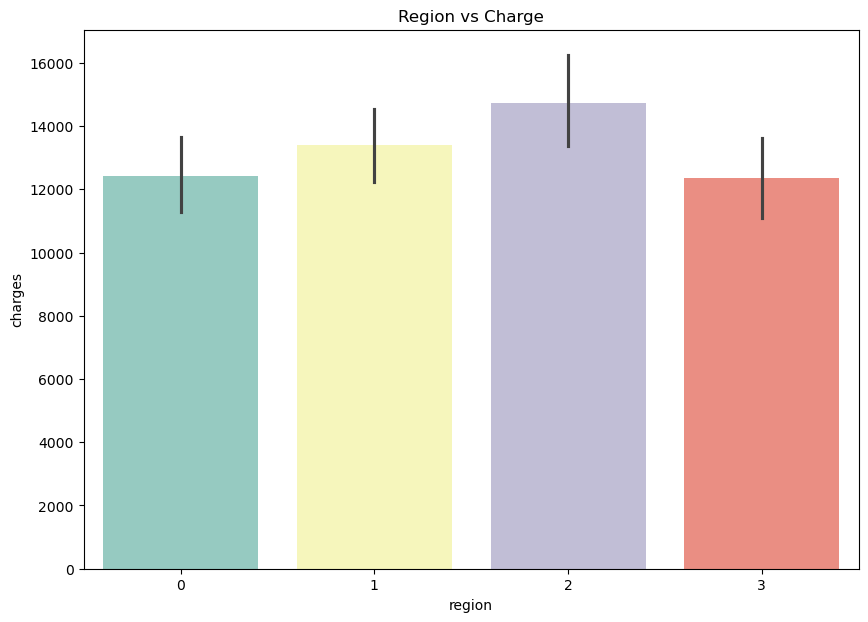

In [73]:
plt.figure(figsize=(10,7))
plt.title('Region vs Charge')
sns.barplot(x='region', y='charges', data=data_copy, hue='region', palette='Set3', legend=False)
plt.show()

Text(0.5, 1.0, 'BMI VS Charge')

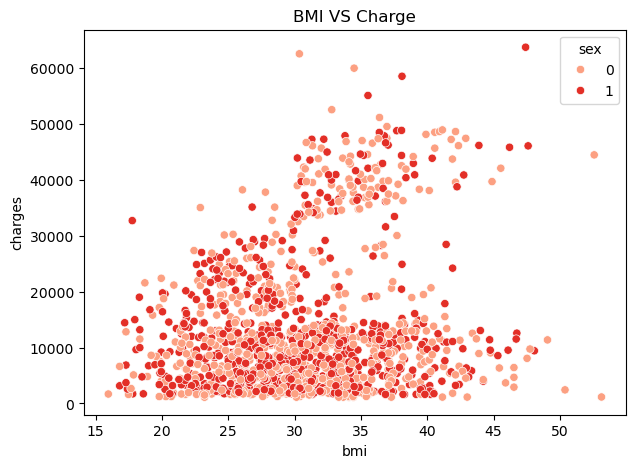

In [74]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='bmi',y='charges',hue='sex',data=data_copy,palette='Reds')
plt.title('BMI VS Charge')

<Axes: title={'center': 'Smoker vs Charge'}, xlabel='smoker', ylabel='charges'>

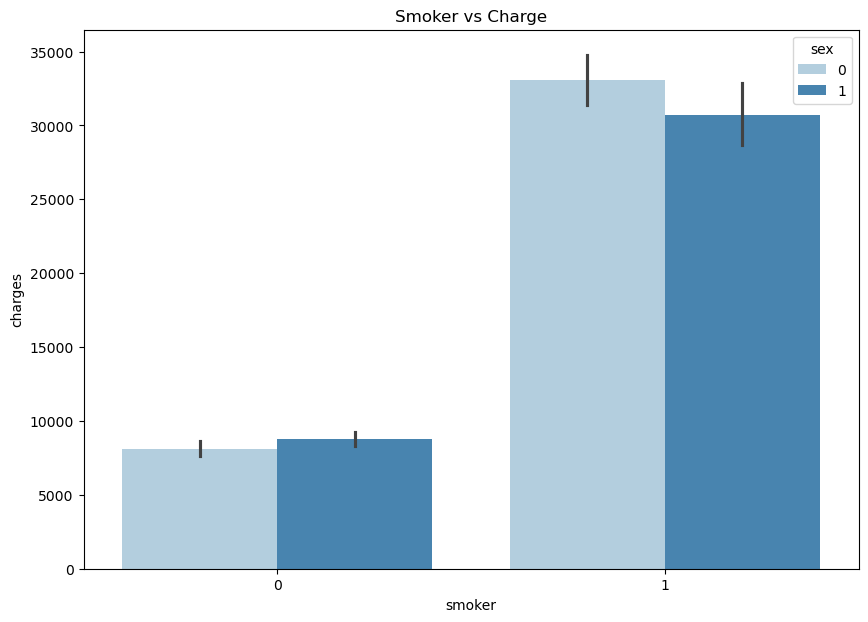

In [75]:
plt.figure(figsize=(10,7))
plt.title('Smoker vs Charge')
sns.barplot(x='smoker',y='charges',data=data_copy,palette='Blues',hue='sex')

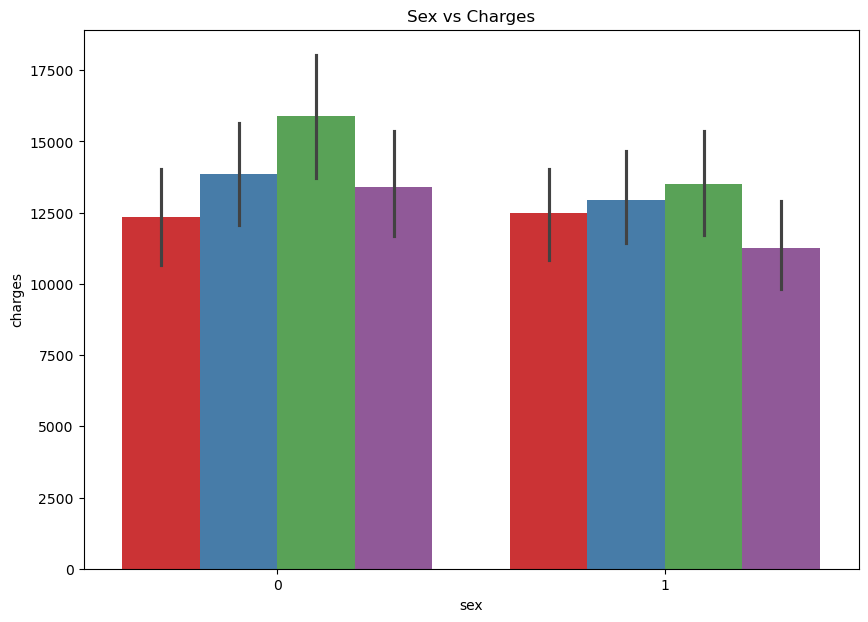

In [76]:
plt.figure(figsize=(10,7))
plt.title('Sex vs Charges')
sns.barplot(x='sex', y='charges', data=data_copy, hue='region', palette='Set1', legend=False)
plt.show()

### Plotting Skew and Kurtosis

In [77]:
print('Printing Skewness and Kurtosis for all columns')
print()
for col in list(data_copy.columns):
    print('{0} : Skewness {1:.3f} and  Kurtosis {2:.3f}'.format(col,data_copy[col].skew(),data_copy[col].kurt()))

Printing Skewness and Kurtosis for all columns

age : Skewness 0.056 and  Kurtosis -1.245
sex : Skewness 0.021 and  Kurtosis -2.003
bmi : Skewness 0.284 and  Kurtosis -0.051
children : Skewness 0.938 and  Kurtosis 0.202
smoker : Skewness 1.465 and  Kurtosis 0.146
region : Skewness -0.038 and  Kurtosis -1.329
charges : Skewness 1.516 and  Kurtosis 1.606


Text(0, 0.5, 'Count')

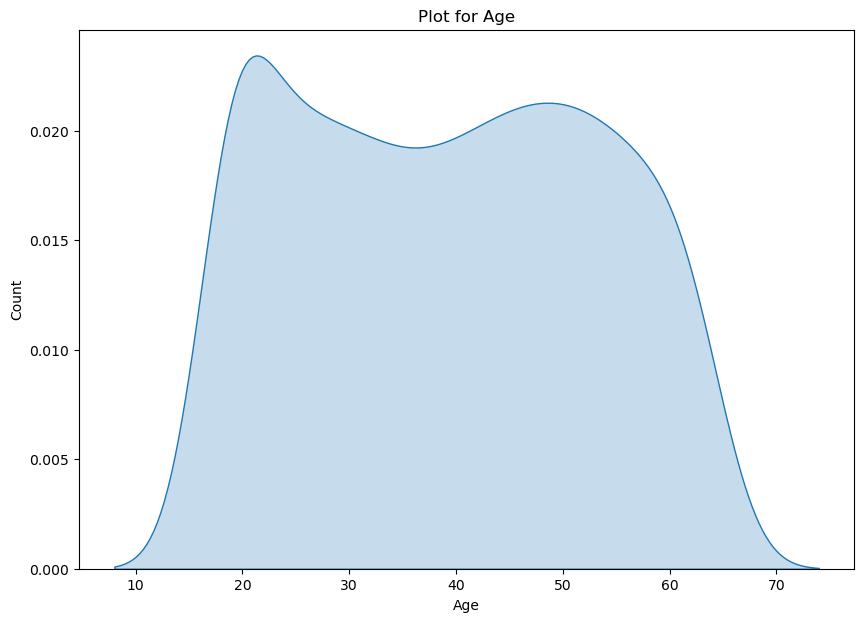

In [79]:
plt.figure(figsize=(10,7))
sns.kdeplot(data_copy['age'], fill=True) 
plt.title('Plot for Age')
plt.xlabel('Age')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

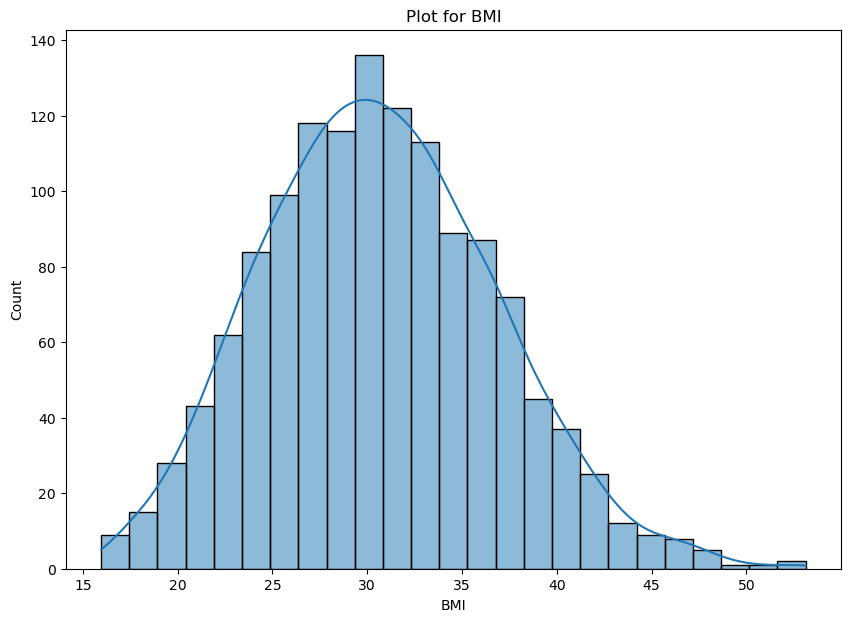

In [86]:
plt.figure(figsize=(10, 7))
sns.histplot(data_copy['bmi'], kde=True)  # kde=True adds a KDE overlay
plt.title('Plot for BMI')
plt.xlabel('BMI')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

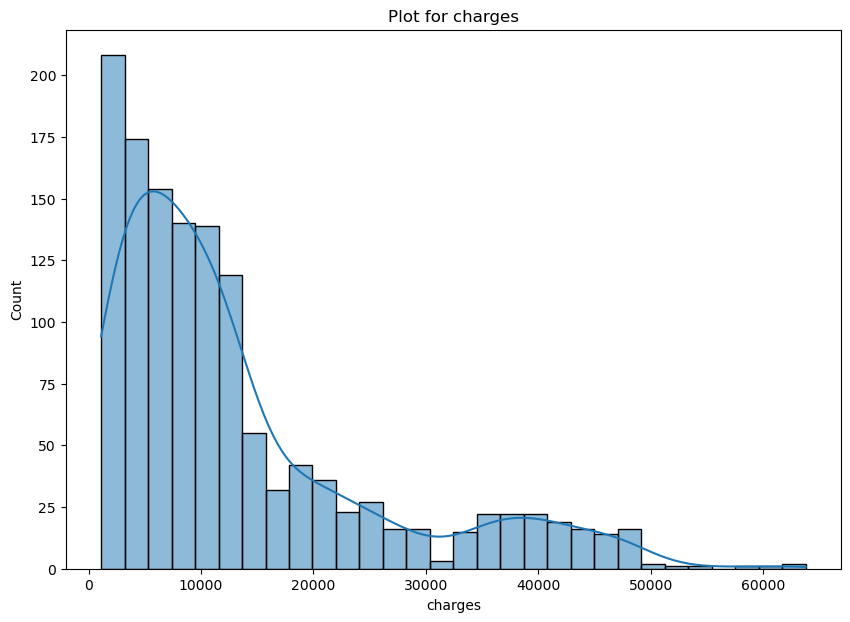

In [88]:
plt.figure(figsize=(10, 7))
sns.histplot(data_copy['charges'], kde=True)  # kde=True adds a KDE overlay
plt.title('Plot for charges')
plt.xlabel('charges')
plt.ylabel('Count')

### There might be few outliers in Charges but then we cannot say that the value is an outlier as there might be cases in which Charge for medical was very les actually!

### Prepating data - We can scale BMI and Charges Column before proceeding with Prediction

In [89]:
from sklearn.preprocessing import StandardScaler
data_pre = data_copy.copy()

tempBmi = data_pre.bmi
tempBmi = tempBmi.values.reshape(-1,1)
data_pre['bmi'] = StandardScaler().fit_transform(tempBmi)

tempAge = data_pre.age
tempAge = tempAge.values.reshape(-1,1)
data_pre['age'] = StandardScaler().fit_transform(tempAge)

tempCharges = data_pre.charges
tempCharges = tempCharges.values.reshape(-1,1)
data_pre['charges'] = StandardScaler().fit_transform(tempCharges)

data_pre.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,1,-0.453320,0,1,3,0.298584
1,-1.509965,0,0.509621,1,0,2,-0.953689
2,-0.797954,0,0.383307,3,0,2,-0.728675
3,-0.441948,0,-1.305531,0,0,0,0.719843
4,-0.513149,0,-0.292556,0,0,0,-0.776802


In [90]:
X = data_pre.drop('charges',axis=1).values
y = data_pre['charges'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print('Size of X_train : ', X_train.shape)
print('Size of y_train : ', y_train.shape)
print('Size of X_test : ', X_test.shape)
print('Size of Y_test : ', y_test.shape)

Size of X_train :  (1070, 6)
Size of y_train :  (1070, 1)
Size of X_test :  (268, 6)
Size of Y_test :  (268, 1)


## Importing Libraries

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

## Linear Regression

In [97]:
%%time
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 3.71 ms


LinearRegression()

In [98]:
cv_linear_reg = cross_val_score(estimator = linear_reg, X = X, y = y, cv = 10)

y_pred_linear_reg_train = linear_reg.predict(X_train)
r2_score_linear_reg_train = r2_score(y_train, y_pred_linear_reg_train)

y_pred_linear_reg_test = linear_reg.predict(X_test)
r2_score_linear_reg_test = r2_score(y_test, y_pred_linear_reg_test)

rmse_linear = (np.sqrt(mean_squared_error(y_test, y_pred_linear_reg_test)))

print('CV Linear Regression : {0:.3f}'.format(cv_linear_reg.mean()))
print('R2_score (train) : {0:.3f}'.format(r2_score_linear_reg_train))
print('R2_score (test) : {0:.3f}'.format(r2_score_linear_reg_test))
print('RMSE : {0:.3f}'.format(rmse_linear))

CV Linear Regression : 0.745
R2_score (train) : 0.741
R2_score (test) : 0.783
RMSE : 0.480


## Support Vector Machine (Regression)

In [105]:
X_c = data_copy.drop('charges',axis=1).values
y_c = data_copy['charges'].values.reshape(-1,1)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y_c,test_size=0.2, random_state=42)

X_train_scaled = StandardScaler().fit_transform(X_train_c)
y_train_scaled = StandardScaler().fit_transform(y_train_c)
X_test_scaled = StandardScaler().fit_transform(X_test_c)
y_test_scaled = StandardScaler().fit_transform(y_test_c)

svr = SVR()
#svr.fit(X_train_scaled, y_train_scaled.ravel())

In [107]:
parameters =  { 'kernel' : ['rbf', 'sigmoid'],
                 'gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
                 'tol' : [0.0001],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100] }
svr_grid = GridSearchCV(estimator=svr, param_grid=parameters, cv=10, verbose=4, n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train_scaled.ravel())

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                         'kernel': ['rbf', 'sigmoid'], 'tol': [0.0001]},
             verbose=4)

In [108]:
svr = SVR(C=10, gamma=0.1, tol=0.0001)
svr.fit(X_train_scaled, y_train_scaled.ravel())
print(svr_grid.best_estimator_)
print(svr_grid.best_score_)

SVR(C=10, gamma=0.1, tol=0.0001)
0.8311276912561496


In [109]:
cv_svr = svr_grid.best_score_

y_pred_svr_train = svr.predict(X_train_scaled)
r2_score_svr_train = r2_score(y_train_scaled, y_pred_svr_train)

y_pred_svr_test = svr.predict(X_test_scaled)
r2_score_svr_test = r2_score(y_test_scaled, y_pred_svr_test)

rmse_svr = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_svr_test)))

print('CV : {0:.3f}'.format(cv_svr.mean()))
print('R2_score (train) : {0:.3f}'.format(r2_score_svr_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_svr_test))
print('RMSE : {0:.3f}'.format(rmse_svr))

CV : 0.831
R2_score (train) : 0.857
R2 score (test) : 0.871
RMSE : 0.359


## Ridge Regressor

In [112]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

steps = [ ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Ridge())]

# Define the pipeline
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('model', Ridge())  # Ridge regression step
])


In [113]:
parameters = { 'model__alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2,1,2,5,10,20,25,35, 43,55,100], 'model__random_state' : [42]}
reg_ridge = GridSearchCV(ridge_pipe, parameters, cv=10)
reg_ridge = reg_ridge.fit(X_train, y_train.ravel())


In [114]:
reg_ridge.best_estimator_, reg_ridge.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', Ridge(alpha=10, random_state=42))]),
 0.7306689105067041)

In [115]:
ridge = Ridge(alpha=20, random_state=42)
ridge.fit(X_train_scaled, y_train_scaled.ravel())
cv_ridge = reg_ridge.best_score_

y_pred_ridge_train = ridge.predict(X_train_scaled)
r2_score_ridge_train = r2_score(y_train_scaled, y_pred_ridge_train)

y_pred_ridge_test = ridge.predict(X_test_scaled)
r2_score_ridge_test = r2_score(y_test_scaled, y_pred_ridge_test)

rmse_ridge = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_linear_reg_test)))
print('CV : {0:.3f}'.format(cv_ridge.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_ridge_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_ridge_test))
print('RMSE : {0:.3f}'.format(rmse_ridge))

CV : 0.731
R2 score (train) : 0.741
R2 score (test) : 0.784
RMSE : 0.465


## RandomForest Regressor

In [116]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the RandomForestRegressor
reg_rf = RandomForestRegressor()

# Define the parameter grid
parameters = { 
    'n_estimators': [600, 1000, 1200],  # Keep this for now
    'max_features': ['sqrt', 'log2', None],  # Include more options for variety
    'max_depth': [40, 50],  # Reduce options to speed up
    'min_samples_split': [5, 7],  # Reduce options to speed up
    'min_samples_leaf': [7, 10],  # Reduce options to speed up
    'criterion': ['squared_error']  # Corrected from 'mse' to 'squared_error'
}

# Use RandomizedSearchCV instead of GridSearchCV
reg_rf_gscv = RandomizedSearchCV(estimator=reg_rf, param_distributions=parameters, n_iter=20, cv=5, n_jobs=-1, random_state=42)
reg_rf_gscv = reg_rf_gscv.fit(X_train_scaled, y_train_scaled.ravel())

CPU times: total: 3.53 s
Wall time: 50.7 s


In [117]:
reg_rf_gscv.best_score_, reg_rf_gscv.best_estimator_

(0.8457443800828182,
 RandomForestRegressor(max_depth=40, max_features=None, min_samples_leaf=10,
                       min_samples_split=7, n_estimators=1000))

In [118]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                       n_estimators=1200)
rf_reg.fit(X_train_scaled, y_train_scaled.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [119]:
cv_rf = reg_rf_gscv.best_score_

y_pred_rf_train = rf_reg.predict(X_train_scaled)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

y_pred_rf_test = rf_reg.predict(X_test_scaled)
r2_score_rf_test = r2_score(y_test_scaled, y_pred_rf_test)

rmse_rf = np.sqrt(mean_squared_error(y_test_scaled, y_pred_rf_test))

print('CV : {0:.3f}'.format(cv_rf.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test))
print('RMSE : {0:.3f}'.format(rmse_rf))

CV : 0.846
R2 score (train) : 0.885
R2 score (test) : 0.879
RMSE : 0.348


In [122]:
models = [('Linear Regression', rmse_linear, r2_score_linear_reg_train, r2_score_linear_reg_test, cv_linear_reg.mean()),
          ('Ridge Regression', rmse_ridge, r2_score_ridge_train, r2_score_ridge_test, cv_ridge.mean()),
          ('Support Vector Regression', rmse_svr, r2_score_svr_train, r2_score_svr_test, cv_svr.mean()),
          ('Random Forest Regression', rmse_rf, r2_score_rf_train, r2_score_rf_test, cv_rf.mean())   
         ]

In [123]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

,Model,RMSE,R2_Score(training),R2_Score(test),Cross-Validation
0,Linear Regression,0.479808,0.741410,0.782694,0.744528
1,Ridge Regression,0.465206,0.741150,0.783800,0.730669
2,Support Vector Regression,0.358769,0.857235,0.871285,0.831128
3,Random Forest Regression,0.347960,0.884616,0.878924,0.845744


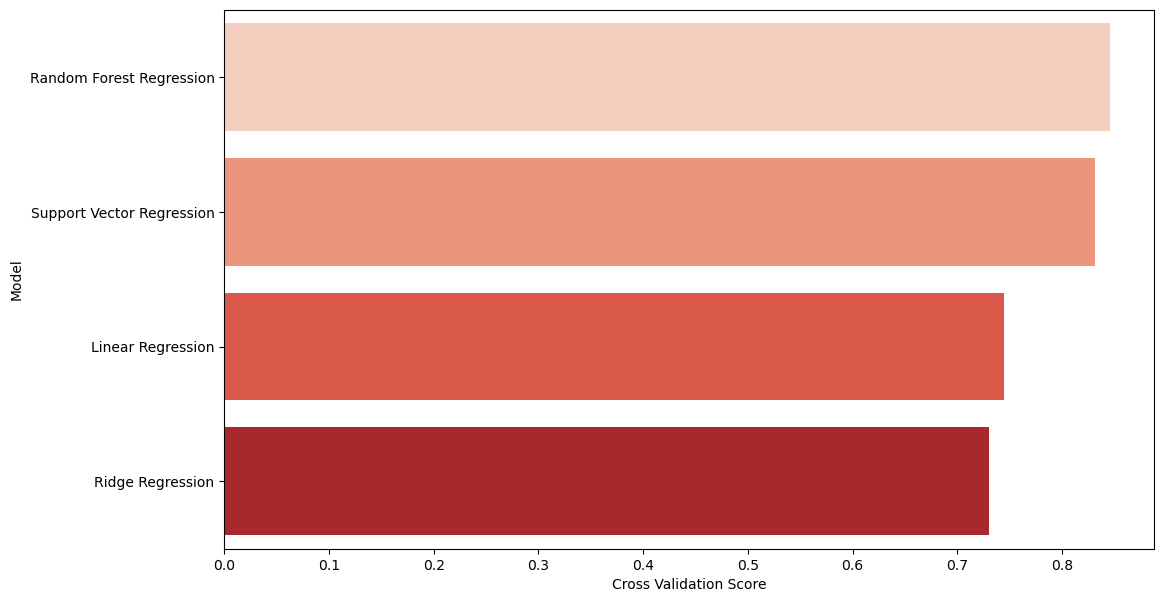

In [125]:
plt.figure(figsize=(12,7))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model',data = predict, hue='Model', palette='Reds')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')
plt.show()

## Training Data without Scaling for RandomClassifier

In [126]:
data_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,0,21984.47061
4,32,0,28.880,0,0,0,3866.85520


In [127]:
X_ = data_copy.drop('charges',axis=1).values
y_ = data_copy['charges'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_,test_size=0.2, random_state=42)

print('Size of X_train_ : ', X_train_.shape)
print('Size of y_train_ : ', y_train_.shape)
print('Size of X_test_ : ', X_test_.shape)
print('Size of Y_test_ : ', y_test_.shape)

Size of X_train_ :  (1070, 6)
Size of y_train_ :  (1070, 1)
Size of X_test_ :  (268, 6)
Size of Y_test_ :  (268, 1)


In [128]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                       n_estimators=1200)
rf_reg.fit(X_train_, y_train_.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [129]:
y_pred_rf_train_ = rf_reg.predict(X_train_)
r2_score_rf_train_ = r2_score(y_train_, y_pred_rf_train_)

y_pred_rf_test_ = rf_reg.predict(X_test_)
r2_score_rf_test_ = r2_score(y_test_, y_pred_rf_test_)

print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train_))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test_))

R2 score (train) : 0.885
R2 score (test) : 0.878


In [130]:
import pickle

Pkl_Filename = "rf_tuned.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rf_reg, file)

In [131]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    rf_tuned_loaded = pickle.load(file)

In [132]:
rf_tuned_loaded

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [133]:
pred=rf_tuned_loaded.predict(np.array([20,1,28,0,1,3]).reshape(1,6))[0]

In [134]:
print('{0:.3f}'.format(pred))

18973.561
